# Model Validation - Failure Classification

This notebook aims to test the developed model usinf the test set provided

In [13]:
# imports
import os
import sys
import warnings
import pickle
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick import ROCAUC

# ignore warnings
warnings.filterwarnings('ignore')

# append additional models
sys.path.append('../../modules')
from utils.ml_utils import MLutils

# constant definition
DATASOURCE = '../../data/1_raw'
DATANAME = 'PM_test.txt'
best_model_id = 'ff976ed13e3c4fd0895bcf0cd67d432e'  # obtained from mlflow ui
MODEL_PATH = '../../models/mlruns/2/'

# list of real columns names (provided by project description) 
real_cols = [
    'asset_id',
    'runtime',
    'set1',
    'set2',
    'set3',
]

for i in range(1, 22):
    real_cols.append(f'tag{i}')

# create class instance
mlu = MLutils()

## Load data and make feature engineering

In this step, all the data preparations and cleaning done for the train set must be repeated for the test test. Only the definition of class failure must use the maximum RLU observed in train set, to avoid information leakage.

In [2]:
# load train set to perform feature engineering
data_train = pd.read_csv(os.path.join(DATASOURCE, 'PM_train.txt'), header=None, sep=' ')

data_train.drop([26,27], axis=1, inplace=True)

# change the columns names
data_train.columns = real_cols

# check the maximum runtime for each asset_id
time_per_asset = pd.DataFrame(data_train.groupby(['asset_id'])['runtime'].max().values,
                              columns=['max_runtime'],
                              index=data_train.groupby(['asset_id'])['runtime'].max().index)

In [3]:
# define function to create classes
def create_failure_class(row,
                         time_per_asset: pd.DataFrame) -> int:
    """
    create a failure class
    1 - the asset will fail in runtime + 20 cycles
    0 - the asset will not fail runtime + 20 cycles

    Parameters
    ----------
    row : pd.DataFrame
        dataframe row
    time_per_asset : pd.DataFrame
        dataframe with the maximum
        runtime for each asset

    Returns
    -------
    int
        failure class
    """

    # business strategic information
    CYCLE_THRESHOLD = 20 

    # extract the maximum runtime for the id
    max_runtime = time_per_asset.loc[row['asset_id'], 'max_runtime']

    # check if the runtime + 20 cycles surpass maximum history failure runtime
    if row['runtime'] + CYCLE_THRESHOLD > max_runtime:
        return 1
    else:
        return 0

In [4]:
# load the test set
data_test = pd.read_csv(os.path.join(DATASOURCE, DATANAME), header=None, sep=' ')
data_test.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [5]:
# there are two additional columns (26 and 27) with NaNs values
# remove those
data_test.drop([26,27], axis=1, inplace=True)

# change the columns names
data_test.columns = real_cols
data_test.head()

,asset_id,runtime,set1,set2,set3,tag1,tag2,tag3,tag4,tag5,...,tag12,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [6]:
# build failure classes applying the function
data_test['failure']=data_test[['asset_id', 'runtime']].apply(create_failure_class, time_per_asset=time_per_asset, axis=1)
data_test.head()

,asset_id,runtime,set1,set2,set3,tag1,tag2,tag3,tag4,tag5,...,tag13,tag14,tag15,tag16,tag17,tag18,tag19,tag20,tag21,failure
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,0


## Model Load

The model is loaded by using the best id found when inspecting the `mlflow ui` for the regression models.

In [7]:
# load best model
model_full_path = os.path.join(MODEL_PATH, best_model_id, 'artifacts', 'model', 'model.pkl')
model = pickle.load(open(model_full_path, 'rb'))

In [8]:
# load the best model inputs
inputs_full_path = os.path.join(MODEL_PATH, best_model_id, 'artifacts', 'model', 'input_example.json')
inputs = json.load(open(inputs_full_path, 'r'))['columns']

## Make predictions on the test set

In this step, the best model found is used to make the predictions on the test set.

In [9]:
# make the predictions
yhat = model.predict(data_test[inputs])

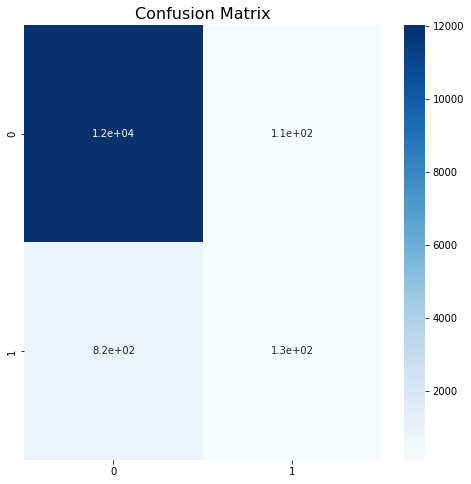

In [10]:
# validate model
fig = mlu.classification_performance_fig(data_test['failure'], yhat)
fig.show()

In [11]:
# calculate the metrics
precision, recall, f1 = mlu.calculate_classification_metrics(data_test['failure'], yhat)

print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Recall: 0.5365853658536586
Precision: 0.1382198952879581
F1 Score: 0.21981681931723565


Like the verified in the regression analysis, the model does not performed well in the dataset. It must be due to variance for multiple asset id for the same runtime. A clusterization or binning approach has potential to solve such issues.

## Feature Importance Analysis

This last step will look into the model feature importance in order to take insights about the failure condition.

In [19]:
# extract feature importances
feat_imp = pd.DataFrame(model['model'].feature_importances_, columns=['importance'])
for i in range(7, 15):
    feat_imp.loc[i, 'importance'] = 0          # since all values of importances sum up to 1, the last must be zero
feat_imp['features'] = inputs 

feat_imp = feat_imp.sort_values(by=['importance'])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


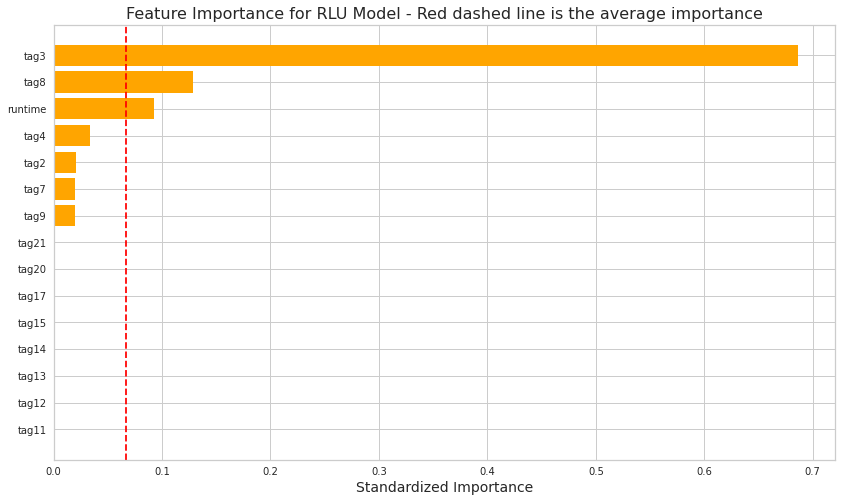

In [20]:
# make a barplot to illustrate the findings
plt.figure(figsize=(14,8))
plt.barh(y=feat_imp['features'], width=feat_imp['importance'], color='orange')
plt.axvline(x=feat_imp.importance.mean(), ls = '--', color='red')
plt.xlabel('Standardized Importance', size=14)
plt.title('Feature Importance for Failure Model - Red dashed line is the average importance', size=16)
plt.show()

It's interesting to note the not all the inputted features presented significant importance to the model to classify the failures. Top 3 included `tag3`, `tag8` and `runtime` as the most important features to monitor. The plot above can be used as an input for a new modeling round, which could eliminate manually the least important variables. Here, it can be seen that the `RFECV` was not so effective as well.

According to exploratory data analysis, longer runtimes are associated with higher probability of failure in the next 20 cycles. The `tag3` has also positive correlation with the increase of probability of failure in the next 20 cycles, as `tag8` does.

These also can be used as monitoring variables, to raise alarms when they reach some threshold.

## Effect of Probability Threshold

Since the classification model allows the estimation of probability of each row to be of positive class, we can assess the effect of the probability threshold in the decision of failure classes.

In [21]:
# make the estimations of probability
data_test[['prob_0', 'prob_1']] = model.predict_proba(data_test[inputs])
data_test.head()

,asset_id,runtime,set1,set2,set3,tag1,tag2,tag3,tag4,tag5,...,tag15,tag16,tag17,tag18,tag19,tag20,tag21,failure,prob_0,prob_1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,0,0.999960,0.000040
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,0,0.999960,0.000040
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,0,0.999958,0.000042
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,0,0.999960,0.000040
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,0,0.999958,0.000042


In [22]:
# assess the effect of several probability thresholds
prec = []
f1 = []
recall = []
for p in np.arange(0.01, 1.01, 0.01):

    # estimate classes with new probability threshold
    data_test['new_failure_class'] = data_test['prob_1'].apply(lambda x: 1 if x > p else 0)

    # calculate the new performance metrics
    precision, recall_, f1_ = mlu.calculate_classification_metrics(data_test['failure'], data_test['new_failure_class'])

    # append metrics
    prec.append(precision)
    recall.append(recall_)
    f1.append(f1_)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


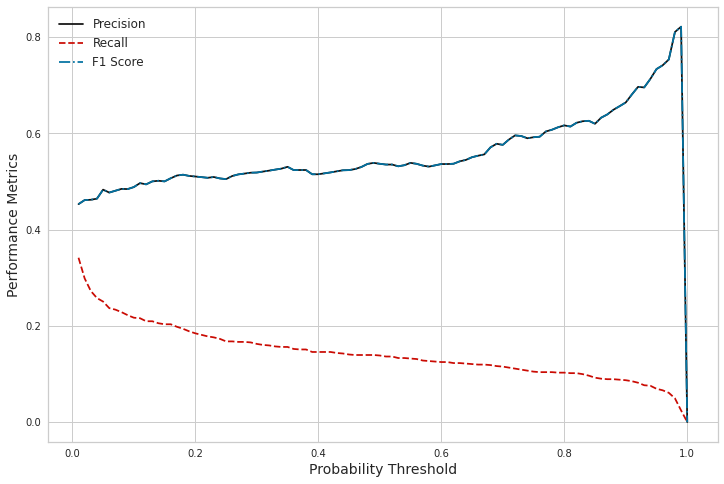

In [23]:
# create plot of probability threshold
plt.figure(figsize=(12,8))
plt.plot(np.arange(0.01, 1.01, 0.01), prec, 'k-', label='Precision')
plt.plot(np.arange(0.01, 1.01, 0.01), recall, 'r--', label='Recall')
plt.plot(np.arange(0.01, 1.01, 0.01), prec, 'b-.', label='F1 Score')
plt.xlabel('Probability Threshold', size=14)
plt.ylabel('Performance Metrics', size=14)
plt.legend(loc='best',prop={'size':12})
plt.show()

The plot shows that by using the selected model, the best situation is to have a more conservative position. This is because the plot shows that increasing the minimum probability necessary to accept the row as positive class results in an increase in precision and f1 score, at cost of having more false negatives.

There are opportunities to improve the model, but using a conservative approach, the present solution can predict with a good precision (above 80 %) if the asset will fail in the next 20 cycles. However, it is important to emphasize that there will be several false negatives, which will result in an increase in antecipated maintenance costs.